In [5]:
%pip install pandas --quiet
%pip install numpy --quiet
%pip install backtesting --quiet
%pip install scikit-learn --quiet
%pip install seaborn --quiet
%pip install matplotlib --quiet

import pandas as pd
import numpy as np

# importing sample data
from backtesting.test import EURUSD, SMA
from backtesting import Backtest, Strategy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
data = EURUSD.copy()
data.head()

,Open,High,Low,Close,Volume
2017-04-19 09:00:00,1.07160,1.07220,1.07083,1.07219,1413
2017-04-19 10:00:00,1.07214,1.07296,1.07214,1.07260,1241
2017-04-19 11:00:00,1.07256,1.07299,1.07170,1.07192,1025
2017-04-19 12:00:00,1.07195,1.07280,1.07195,1.07202,1460
2017-04-19 13:00:00,1.07200,1.07230,1.07045,1.07050,1554


In [7]:
# We'll try to map several price-derived features and common technical indicators to the price point 2 days in the future. 

# Function that calculates the upper and lower Bollinger Bands for the given data.
def BBANDS(data, n_lookback, n_std):

    hlc3 = (data.High + data.Low + data.Close) / 3
    # .rolling(), calculates rolling mean and std on hlc/3 over a specified lookback period/window.
    mean = hlc3.rolling(n_lookback).mean()
    std = hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower

# Various SMA's calculated from closing prices. BB's calculated with period of 20 lookback and STD multiplier of 2.
close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Price-derived features

# Feature Engineering with *normalized* versions of SMA. Helps to make these features useable over different price levels. 
# By dividing by the close price, the features become *relative* measures, making them more useful for analysis.
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features (Momentum, BB's, Sentiment)

# Calculates the percentage change in the closing price compared to the price two periods ago. (Simple momentum feature)
data['X_MOM'] = data.Close.pct_change(periods=2)
# Calculates price distance from upper/lower BB and width of BB.
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close

# Creates a binary feature based on a date range. '~' means True (1) outside that date, False inside (0).
# Obtain actual data for this feature by parsing news sources, Twitter sentiment, Stocktwits or similar. Dummy feature for now.
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features incase needed.
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

# drops any rows with missing values, ensures all the reminaing values are of type float.
data = data.dropna().astype(float)
data.head()

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_Sentiment,X_day,X_hour
2017-04-25 12:00:00,1.08879,1.08962,1.08866,1.08890,1005.0,0.000934,0.001711,0.005324,0.010199,0.000777,0.003613,0.004875,0.000928,0.000562,-0.004080,0.004641,1.0,1.0,12.0
2017-04-25 13:00:00,1.08888,1.09016,1.08797,1.09000,1340.0,0.001577,0.002481,0.005945,0.011034,0.000904,0.003463,0.005090,0.001093,-0.000265,-0.004834,0.004569,1.0,1.0,13.0
2017-04-25 14:00:00,1.08997,1.09328,1.08902,1.09281,3642.0,0.003550,0.004726,0.008085,0.013392,0.001176,0.003359,0.005307,0.003591,-0.002029,-0.007627,0.005599,1.0,1.0,14.0
2017-04-25 15:00:00,1.09284,1.09412,1.09198,1.09409,1651.0,0.004024,0.005558,0.008800,0.014344,0.001533,0.003243,0.005544,0.003752,-0.002038,-0.009311,0.007273,1.0,1.0,15.0
2017-04-25 16:00:00,1.09407,1.09499,1.09386,1.09492,966.0,0.004172,0.005938,0.009074,0.014882,0.001766,0.003136,0.005808,0.001931,-0.001560,-0.010578,0.009019,1.0,1.0,16.0


In [8]:
# Our dependent variable is price (return) two days in the future, simplified into values of 1, -1, and 0. When the return after 2 days is +, -, or neutral.
# functions used to prepate model input data X and dependent output variable 'y'.

# Returns all the columns (features) with 'X' in them, removing all the price rows. Returns the values of the filtered columns as a NumPy array.
def get_X(data):
    return data.filter(like='X').values

def get_y(data):
    # output variable 'y', returns after roughly two days
    # calculates % change over closing price over 48 periods. Shifts these calculated returns -48 hours to align with original data.
    y = data.Close.pct_change(48).shift(-48)  
    # If the returns are small negative/positive, then just sets them to zero.
    y[y.between(-.004, .004)] = 0  
    # simplifies positive and negative returns to boolean values.           
    y[y > 0] = 1
    y[y < 0] = -1
    return y

# Return (X, y) without NaN values
def get_clean_Xy(df):
    # Obtains 'X' and 'y'
    X = get_X(df)
    y = get_y(df).values
    # Finds Nan values in 'y', saves them to an array of 0's and 1's.
    isnan = np.isnan(y)
    # Only saves rows with 'not NaN'. Removes NaNs so only numbers remain.
    X = X[~isnan]
    y = y[~isnan]
    # Returns 'X' and 'y' without NaN values
    return X, y


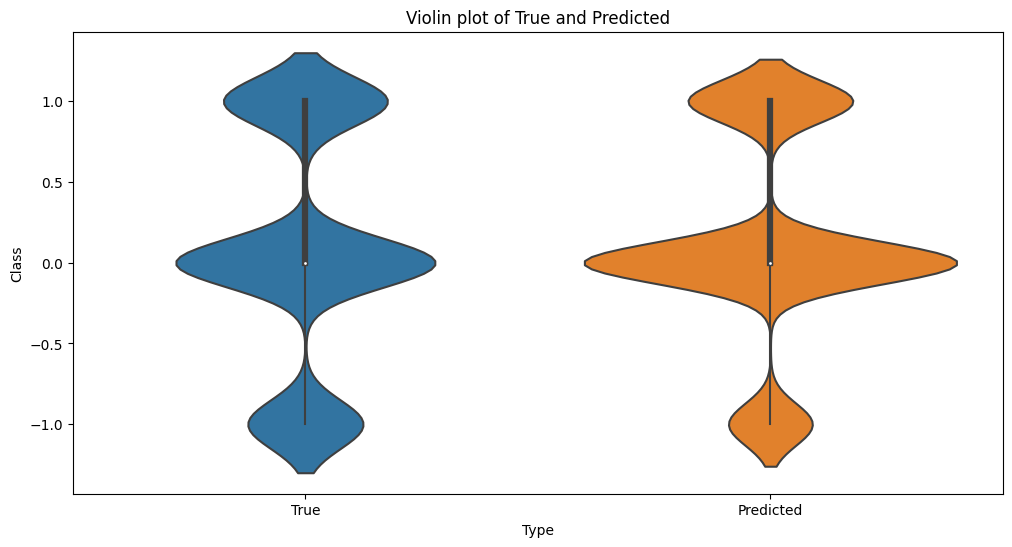

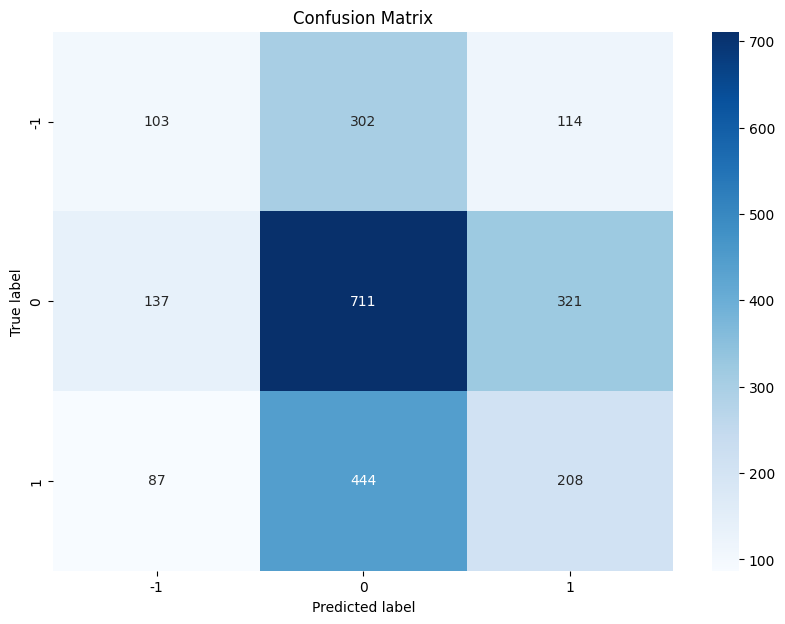

Classification accuracy:  0.4210960032962505


In [11]:
# Use a simple k-nearest neighbors (kNN) algorithm from sklearn.

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)
# kNN Model the output based on 7 nearest neighbors
model_kNN = KNeighborsClassifier(7)  
# fits the model
model_kNN.fit(X_train, y_train)
# predicts with the model
y_pred = model_kNN.predict(X_test)
# Calculates mean of the boolean array. True where they match, false where they don't. ('y' is only -1, 0, or 1 in the pre-processing)
classification_accuracy = np.mean(y_test == y_pred)
print('Classification accuracy: ', classification_accuracy)

# Violin Plot
df = pd.DataFrame({'True': y_test, 'Predicted': y_pred})

# All values in a single column and an additional column telling if it's a prediction or true value.
df_melted = df.melt(value_vars=['True', 'Predicted'], var_name='Type', value_name='Class')

plt.figure(figsize=(12, 6))
sns.violinplot(x='Type', y='Class', data=df_melted)
plt.title('Violin plot of True and Predicted')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index = [-1, 0, 1], columns = [-1, 0, 1])

plt.figure(figsize = (10,7))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
# Integrate our ML model with backtesting.py. Buys whenever the forecast is positive (+1). Sells whenever the forecast is (-1).
# (Forecast is where the price in 2 days is predicted to go up/down). Also sets reasonable sl and tp levels.

N_TRAIN = 800

class MLTrainOnceStrategy(Strategy):
    sl_tp_factor = .004

    def init(self):        
        # initializes our kNN ML model, using 7 nearest neighbors.
        self.model_kNN = KNeighborsClassifier(7)  
        # Grabs those first 'N_TRAIN' rows of data from our 5,000 rows of 'X' and 'y', saves to 'df'.
        df = self.data.df.iloc[:N_TRAIN]
        # Makes sure the 'N_TRAIN' rows for 'X' and 'y' data are free of NaN entries.
        X, y = get_clean_Xy(df)
        # Trains (fits) the model using our clean 'X' and 'y' subset of 'N_TRAIN' rows.
        self.model_kNN.fit(X, y)
        # Create and display 'y' indicator by getting the calculated 'y' values from the data.df price data.
        self.I(get_y, self.data.df, name='y_true')
        # Saves array to self.forecasts. It's empty array filled with all-NaN values. Later, forecasted values can be filled with actual predictions.
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Ensures that trading/forecasting are performed only on the out-of-sample data that hasn't been trained on.
        if len(self.data) < N_TRAIN:
            return

        # Extracts the high, low, and close prices of the current data point.
        high, low, close = self.data.High, self.data.Low, self.data.Close
        # Extracts the current time which is the last index in our data array for our current data point.
        current_time = self.data.index[-1]

        # Obtains the last row of data from 'X' as the input for prediction
        X = get_X(self.data.df.iloc[-1:])
        # Makes and saves the trained models prediction based on that row.
        forecast = self.model_kNN.predict(X)[0]
        # Inputs the prediction into our forecasts empty array.
        self.forecasts[-1] = forecast
        
        # Sets an upper and lower point from the last current price to take profit or stop out. (last close * sl_tp_factor).
        # closing price of 100 and 0.004 factor: 100 * (1 + np.array([0.004, -0.004])) Would be np.array([100.4, 99.6])
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.sl_tp_factor)
        # If our forecast is upwards and we aren't currently long, buy. Vice versa for short. Position size is 50% of current equity.
        if forecast == 1 and not self.position.is_long:
            self.buy(size=.5, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.5, tp=lower, sl=upper)

        # Dynamically adjusts the stop loss, making it more aggressive on trades that have been open for more than 1 day.
        # Iterate through list of open trades
        for trade in self.trades:
            # If open for more than two days
            if current_time - trade.entry_time > pd.Timedelta(days=1):
                # Adjust the stop loss to whichever is closer between the current stop loss and the high/low of the current day.
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)

# 20x leverage
bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

Start                     2017-04-25 12:00:00
End                       2018-02-07 15:00:00
Duration                    288 days 03:00:00
Exposure Time [%]                   42.032238
Equity Final [$]                 11519.973656
Equity Peak [$]                  11681.912148
Return [%]                          15.199737
Buy & Hold Return [%]               12.869869
Return (Ann.) [%]                   15.597995
Volatility (Ann.) [%]               38.109103
Sharpe Ratio                         0.409298
Sortino Ratio                         0.73407
Calmar Ratio                         0.609853
Max. Drawdown [%]                   -25.57665
Avg. Drawdown [%]                   -5.672613
Max. Drawdown Duration       75 days 05:00:00
Avg. Drawdown Duration       12 days 13:00:00
# Trades                                  214
Win Rate [%]                        52.336449
Best Trade [%]                       0.578258
Worst Trade [%]                     -0.424983
Avg. Trade [%]                    

In [13]:
bt.plot()

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p1643', ...)

In [ ]:

# Base model. Would want better features, better models (deep learning), better money mangement strategies.

# Ideas:
# Data is key, design features to correlate with target.
# Instead of modeling a single target variable 'y', you could model multiple targets.
# Model everything: forecast price, volume, multiple time frames, momentum features, SL/TP levels
# More rigorous threshold to enter a trade.